48
[[-1.  0. -1.  0.  0.  0.  0.  0.  0.]
 [-1. -1.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.  0.  0.]
 [-1.  1. -1.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.]
 [ 1. -1.  1.  0.  0.  0.  0.  0.  0.]
 [ 1. -1. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1. -1.  0.  0.  0.  0.  0.  0.]
 [-1. -1.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.  0.  0.]
 [ 1. -1.  1.  0.  0.  0.  0.  0.  0.]
 [ 1.  1.  1.  0.  0.  0.  0.  0.  0.]
 [-1. -1.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [-1.  1. -1.  0.  0.  0.  0.  0.  0.]
 [ 1. -1.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  1. -1.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  1.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1. -1. 

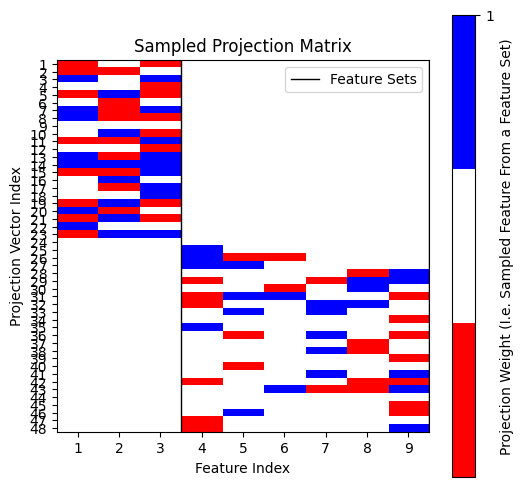

In [ ]:
"""
=================================================================================
Demonstrate and visualize a multi-view projection matrix for an axis-aligned tree
=================================================================================

This example shows how multi-view projection matrices are generated for a decision tree,
specifically the :class:`treeple.tree.MultiViewDecisionTreeClassifier`.

Multi-view projection matrices operate under the assumption that the input ``X`` array
consists of multiple feature-sets that are groups of features important for predicting
``y``.

For details on how to use the hyperparameters related to the multi-view, see
:class:`treeple.tree.MultiViewDecisionTreeClassifier`.
"""

# import modules
# .. note:: We use a private Cython module here to demonstrate what the patches
#           look like. This is not part of the public API. The Cython module used
#           is just a Python wrapper for the underlying Cython code and is not the
#           same as the Cython splitter used in the actual implementation.
#           To use the actual splitter, one should use the public API for the
#           relevant tree/forests class.

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import ScalarMappable
from matplotlib.colors import ListedColormap

from treeple._lib.sklearn.tree._criterion import Gini
from treeple.tree._oblique_splitter import MultiViewObliqueSplitterTester

criterion = Gini(1, np.array((0, 1)))
min_samples_leaf = 1
min_weight_leaf = 0.0
random_state = np.random.RandomState(10)

# we "simulate" three feature sets, with 3, 2 and 4 features respectively
feature_set_ends = np.array([3, 9], dtype=np.intp)
n_feature_sets = len(feature_set_ends)

feature_combinations = 2
monotonic_cst = None
missing_value_feature_mask = None


# initialize some dummy data
X = np.repeat(np.arange(feature_set_ends[-1]).astype(np.float32), 8).reshape(8, -1)
y = np.array([0, 0, 0, 0, 1, 1, 1, 1]).reshape(-1, 1).astype(np.float64)


# %%
# Sampling split candidates scaled to each feature-set dimensionality
# -------------------------------------------------------------------
# In the previous setup, we do not specify the ``max_features_per_set`` parameter.
# This results in the splitter sampling from all features uniformly. However, we can
# also specify ``max_features_per_set`` to sample from each feature set with a different
# scaling factor. For example, if we want to sample from the first feature set three times
# more than the second feature set, we can specify ``max_features_per_set`` as follows:
# ``max_features_per_set = [3, 1]``. This will sample from the first feature set three times
# and the second feature set once.
#
# .. note:: In practice, this is controlled by the ``apply_max_features_per_feature_set`` parameter
#   in :class:`treeple.tree.MultiViewDecisionTreeClassifier`.

max_features_per_set_ = np.array([24, 24], dtype=int)
max_features = np.sum(max_features_per_set_)
print(max_features)
sample_weight = np.ones(int(max_features * feature_combinations))

splitter = MultiViewObliqueSplitterTester(
    criterion,
    max_features,
    min_samples_leaf,
    min_weight_leaf,
    random_state,
    monotonic_cst,
    feature_combinations,
    feature_set_ends,
    n_feature_sets,
    max_features_per_set_,
    # False,
    True
)
splitter.init_test(X, y, sample_weight, missing_value_feature_mask)

# Here, we sampled 1 feature from the first feature set, 2 features from the second feature set
# and 3 features from the third feature set.
projection_matrix = splitter.sample_projection_matrix_py()
print(projection_matrix)

# Create a heatmap to visualize the indices
fig, ax = plt.subplots(figsize=(6, 6))
cmap = ListedColormap(['red', 'white', 'blue'])

ax.imshow(
    projection_matrix, cmap=cmap, aspect=feature_set_ends[-1] / max_features, interpolation="none",vmin = -1, vmax = 1
)
ax.axvline(feature_set_ends[0] - 0.5, color="black", linewidth=1, label="Feature Sets")
for iend in feature_set_ends[1:]:
    ax.axvline(iend - 0.5, color="black", linewidth=1)

ax.set(title="Sampled Projection Matrix", xlabel="Feature Index", ylabel="Projection Vector Index")
ax.set_xticks(np.arange(feature_set_ends[-1]))
ax.set_yticks(np.arange(max_features))
ax.set_yticklabels(np.arange(max_features, dtype=int) + 1)
ax.set_xticklabels(np.arange(feature_set_ends[-1], dtype=int) + 1)
ax.legend()

# Create a mappable object
sm = ScalarMappable(cmap=cmap)
sm.set_array([])  # You can set an empty array or values here

# Create a color bar with labels for each feature set
colorbar = fig.colorbar(sm, ax=ax, ticks=[-1, 1], format="%d")
colorbar.set_label("Projection Weight (I.e. Sampled Feature From a Feature Set)")
colorbar.ax.set_yticklabels(["-1", "1"])

plt.show()

# %%
# Discussion
# ----------
# As we can see, the multi-view splitter samples split candidates across the feature sets.
# In contrast, the normal splitter in :class:`sklearn.tree.DecisionTreeClassifier` samples
# randomly across all ``n_features`` features because it is not aware of the multi-view structure.
# This is the key difference between the two splitters.
#
# For an example of using the multi-view splitter in practice on simulated data, see
# :ref:`sphx_glr_auto_examples_multiview_plot_multiview_dtc.py`.


48
[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  1.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1. -1.  0.  0.  0.  0.  0.  0.]
 [-1.  0. -1.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1. -1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  1.  0.  0.  0.  0.  0.  0.]
 [-1.  1.  1.  0.  0.  0.  0.  0.  0.]
 [ 1. -1. -1.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  1.  0.  0.  0.  0.  0.  0.]
 [-1. -1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [-1. -1.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0. 

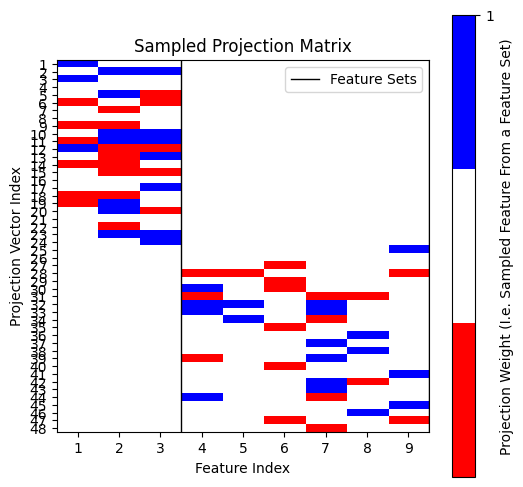

In [3]:
"""
=================================================================================
Demonstrate and visualize a multi-view projection matrix for an axis-aligned tree
=================================================================================

This example shows how multi-view projection matrices are generated for a decision tree,
specifically the :class:`treeple.tree.MultiViewDecisionTreeClassifier`.

Multi-view projection matrices operate under the assumption that the input ``X`` array
consists of multiple feature-sets that are groups of features important for predicting
``y``.

For details on how to use the hyperparameters related to the multi-view, see
:class:`treeple.tree.MultiViewDecisionTreeClassifier`.
"""

# import modules
# .. note:: We use a private Cython module here to demonstrate what the patches
#           look like. This is not part of the public API. The Cython module used
#           is just a Python wrapper for the underlying Cython code and is not the
#           same as the Cython splitter used in the actual implementation.
#           To use the actual splitter, one should use the public API for the
#           relevant tree/forests class.

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import ScalarMappable
from matplotlib.colors import ListedColormap

from treeple._lib.sklearn.tree._criterion import Gini
from treeple.tree._oblique_splitter import MultiViewObliqueSplitterTester

criterion = Gini(1, np.array((0, 1)))
min_samples_leaf = 1
min_weight_leaf = 0.0
# random_state = np.random.RandomState(10)

# we "simulate" three feature sets, with 3, 2 and 4 features respectively
feature_set_ends = np.array([3, 9], dtype=np.intp)
n_feature_sets = len(feature_set_ends)

feature_combinations = 1.5
monotonic_cst = None
missing_value_feature_mask = None


# initialize some dummy data
X = np.repeat(np.arange(feature_set_ends[-1]).astype(np.float32), 8).reshape(8, -1)
y = np.array([0, 0, 0, 0, 1, 1, 1, 1]).reshape(-1, 1).astype(np.float64)

cmap = ListedColormap(['red', 'white', 'blue'])


# %%
# Sampling split candidates scaled to each feature-set dimensionality
# -------------------------------------------------------------------
# In the previous setup, we do not specify the ``max_features_per_set`` parameter.
# This results in the splitter sampling from all features uniformly. However, we can
# also specify ``max_features_per_set`` to sample from each feature set with a different
# scaling factor. For example, if we want to sample from the first feature set three times
# more than the second feature set, we can specify ``max_features_per_set`` as follows:
# ``max_features_per_set = [3, 1]``. This will sample from the first feature set three times
# and the second feature set once.
#
# .. note:: In practice, this is controlled by the ``apply_max_features_per_feature_set`` parameter
#   in :class:`treeple.tree.MultiViewDecisionTreeClassifier`.

max_features_per_set_ = np.array([24, 24], dtype=int)
max_features = np.sum(max_features_per_set_)
print(max_features)
sample_weight = np.ones(int(max_features * feature_combinations))


splitter = MultiViewObliqueSplitterTester(
    criterion,
    max_features,
    min_samples_leaf,
    min_weight_leaf,
    random_state,
    monotonic_cst,
    feature_combinations,
    feature_set_ends,
    n_feature_sets,
    max_features_per_set_,
    False,
    # True
)
splitter.init_test(X, y, sample_weight, missing_value_feature_mask)

# Here, we sampled 1 feature from the first feature set, 2 features from the second feature set
# and 3 features from the third feature set.
projection_matrix = splitter.sample_projection_matrix_py()
print(projection_matrix)

# Create a heatmap to visualize the indices
fig, ax = plt.subplots(figsize=(6, 6))

ax.imshow(
    projection_matrix, cmap=cmap, aspect=feature_set_ends[-1] / max_features, interpolation="none"
)
ax.axvline(feature_set_ends[0] - 0.5, color="black", linewidth=1, label="Feature Sets")
for iend in feature_set_ends[1:]:
    ax.axvline(iend - 0.5, color="black", linewidth=1)

ax.set(title="Sampled Projection Matrix", xlabel="Feature Index", ylabel="Projection Vector Index")
ax.set_xticks(np.arange(feature_set_ends[-1]))
ax.set_yticks(np.arange(max_features))
ax.set_yticklabels(np.arange(max_features, dtype=int) + 1)
ax.set_xticklabels(np.arange(feature_set_ends[-1], dtype=int) + 1)
ax.legend()

# Create a mappable object
sm = ScalarMappable(cmap=cmap)
sm.set_array([])  # You can set an empty array or values here

# Create a color bar with labels for each feature set
colorbar = fig.colorbar(sm, ax=ax, ticks=[-1, 1], format="%d")
colorbar.set_label("Projection Weight (I.e. Sampled Feature From a Feature Set)")
colorbar.ax.set_yticklabels(["-1", "1"])

plt.show()

The shape of our dataset is:  (5, 10) (5, 1) (5,)
(6, 10)


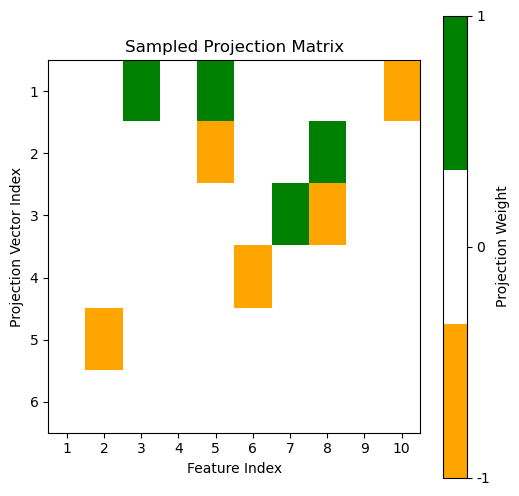

In [2]:
"""
======================================================
Plot the sparse projection matrices of an oblique tree
======================================================

This example shows how projection matrices are generated for an oblique tree,
specifically the :class:`treeple.tree.ObliqueDecisionTreeClassifier`.

The projection matrix here samples a subset of features from the input ``X``
controlled by the parameter ``feature_combinations``. The projection matrix
is sparse when ``feature_combinations`` is small, meaning that it is mostly zero.
The non-zero elements of the projection matrix are the features that are sampled
from the input ``X`` and linearly combined to form candidate split dimensions.

For details on how to use the hyperparameters related to the patches, see
:class:`treeple.tree.ObliqueDecisionTreeClassifier`.
"""

import matplotlib.pyplot as plt

# import modules
# .. note:: We use a private Cython module here to demonstrate what the patches
#           look like. This is not part of the public API. The Cython module used
#           is just a Python wrapper for the underlying Cython code and is not the
#           same as the Cython splitter used in the actual implementation.
#           To use the actual splitter, one should use the public API for the
#           relevant tree/forests class.
import numpy as np
from matplotlib.cm import ScalarMappable
from matplotlib.colors import ListedColormap

from treeple._lib.sklearn.tree._criterion import Gini
from treeple.tree._oblique_splitter import BestObliqueSplitterTester

# %%
# Initialize patch splitter
# -------------------------
# The patch splitter is used to generate patches for the projection matrices.
# We will initialize the patch with some dummy values for the sake of this
# example.

criterion = Gini(1, np.array((0, 1)))
max_features = 6
min_samples_leaf = 1
min_weight_leaf = 0.0
random_state = np.random.RandomState(1)

feature_combinations = 1.5
monotonic_cst = None
missing_value_feature_mask = None

n_features = 10
n_samples = 5

# initialize some dummy data
X = np.ones((n_samples, n_features), dtype=np.float32)
y = np.array([0, 0, 0, 1, 1]).reshape(-1, 1).astype(np.float64)
sample_weight = np.ones(5)

print("The shape of our dataset is: ", X.shape, y.shape, sample_weight.shape)

# %%
# Initialize the splitter
# -----------------------
# The splitter is initialized in the decision-tree classes, but we expose
# a testing interface here to demonstrate how the projection matrices are
# sampled internally.
#
# .. warning:: Do not use this interface directly in practice.

splitter = BestObliqueSplitterTester(
    criterion,
    max_features,
    min_samples_leaf,
    min_weight_leaf,
    random_state,
    monotonic_cst,
    feature_combinations,
)
splitter.init_test(X, y, sample_weight, missing_value_feature_mask)

# %%
# Generate projection matrix
# --------------------------
# Sample the projection matrix that consists of randomly sampled features
# with an average of ``feature_combinations * max_features`` non-zeros
# in the ``(max_features, n_features)`` matrix.

projection_matrix = splitter.sample_projection_matrix_py()
print(projection_matrix.shape)

# Visualize the projection matrix
cmap = ListedColormap(["orange", "white", "green"])

# Create a heatmap to visualize the indices
fig, ax = plt.subplots(figsize=(6, 6))

ax.imshow(projection_matrix, cmap=cmap, aspect=n_features / max_features, interpolation="none")

ax.set(title="Sampled Projection Matrix", xlabel="Feature Index", ylabel="Projection Vector Index")
ax.set_xticks(np.arange(n_features))
ax.set_yticks(np.arange(max_features))
ax.set_yticklabels(np.arange(max_features, dtype=int) + 1)
ax.set_xticklabels(np.arange(n_features, dtype=int) + 1)

# Create a mappable object
sm = ScalarMappable(cmap=cmap)
sm.set_array([])  # You can set an empty array or values here

# Create a color bar with labels for each feature set
colorbar = fig.colorbar(sm, ax=ax, ticks=[0, 0.5, 1], format="%d")
colorbar.set_label("Projection Weight")
colorbar.ax.set_yticklabels(["-1", "0", "1"])

plt.show()

# %%
# Discussion
# ----------
# As we can see, the (sparse) oblique splitter samples random features to
# linearly combine to form candidate split dimensions.
#
# In contrast, the normal splitter in :class:`sklearn.tree.DecisionTreeClassifier` samples
# randomly across all ``n_features`` features.
#
# For an example of using oblique trees/forests in practice on data, see the following
# examples:
#
# - :ref:`sphx_glr_auto_examples_sparse_oblique_trees_plot_oblique_forests_iris.py`
# - :ref:`sphx_glr_auto_examples_sparse_oblique_trees_plot_oblique_random_forest.py`
